# Flower project: convert Pytorch model to onnix

Step 3 of my capstone project is implementing the trained model in a mobile app.
In Step 2 I have created my app.
There are few solutions I want to test:
    - convert the model to onnix with Caffe 2
    - use pysyft and Android worker

# Convert to onnix format

Credits: I am using Pytorch tutorial code on https://pytorch.org/tutorials/advanced/super_resolution_with_caffe2.html
Udacity lesson: https://classroom.udacity.com/nanodegrees/nd188/parts/ef29955b-1133-473a-a46f-c0696c865f97/modules/f9c54fe1-528c-48ea-a29b-2917af192032/lessons/2f20d93e-65cb-4c17-9560-266d6db2303c/concepts/d9843b98-f54c-44a2-92b9-ac07a455fa16

https://heartbeat.fritz.ai/transferring-machine-learning-models-from-pytorch-to-caffe2-and-mobile-using-onnx-10eb266eaacb

https://nbviewer.jupyter.org/github/cedrickchee/data-science-notebooks/blob/master/notebooks/deep_learning/fastai_mobile/shipping_squeezenet_from_pytorch_to_android.ipynb
https://github.com/cedrickchee/pytorch-android

In [12]:
# Some standard imports
import io
import numpy as np

from torch import nn
import torch.onnx
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import caffe2.python.onnx.backend as backend
import onnx

In [3]:
!dir "./trained_classifier.pth"

 Volume in drive C is OS
 Volume Serial Number is 8C39-2646

 Directory of C:\Users\France\Webtotum\Leren\private-ai\flowers

28-Dec-18  01:56 PM       111,601,189 trained_classifier.pth
               1 File(s)    111,601,189 bytes
               0 Dir(s)  56,955,334,656 bytes free


In [4]:
torch_model = models.densenet161(pretrained=False)
torch_model.cpu()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [10]:
def load_model(checkpoint_path):
    chpt = torch.load(checkpoint_path)
    
    if chpt['model'] == 'densenet161':
        model = models.densenet161(pretrained=False)
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Sorry base architecture note recognized")
      
    
    model.class_to_idx = chpt['class_to_idx']
    from collections import OrderedDict
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(n_inputs, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(500, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
    # Put the classifier on the pretrained network
    model.classifier = classifier
    
    model.load_state_dict(chpt['state_dict'])
    
    return model

In [8]:
model_url="./trained_classifier.pth"

In [13]:

# Create the super-resolution model by using the above model definition.
n_inputs = 2208
torch_model=load_model(model_url)

# set the train mode to false since we will only run the forward pass.
torch_model.train(False)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [17]:
# Input to the model
x = torch.randn(1, 3, 224, 224, requires_grad=True)

In [28]:
class_index= torch_model.class_to_idx.items()
class_index
idx_to_class = {val: key for key, val in class_index}

In [10]:
x.shape

torch.Size([1, 3, 224, 224])

In [19]:

# Export the model
torch_out = torch.onnx._export(torch_model,             # model being run
                               x,                       # model input (or a tuple for multiple inputs)
                               "flower_model.onnx", # where to save the model (can be a file or file-like object)
                               export_params=True)      # store the trained parameter weights inside the model file

In [ ]:
# Export an ONNX model from a PyTorch .pt model
 
import torch.onnx
 
# Loading the input PyTorch model and mapping the tensors to CPU
device = torch.device('cpu')
model = torch.load(model_url, map_location=device)
 
# Generate a dummy input that is consistent with the network's arhitecture
dummy_input = torch.randn(1, 3, 224, 224)
 
# Export into an ONNX model using the PyTorch model and the dummy input
torch.onnx.export(torch_model, dummy_input, "flower_model2.onnx")

In [14]:
import caffe2.python.onnx.backend as backend


In [15]:
import json
import operator
with open('cat_to_name.json', 'r') as f:
    label_map = json.load(f)


In [20]:
import caffe2.python.onnx.backend as onnx_caffe2_backend

# Load the ONNX ModelProto object. model is a standard Python protobuf object
model = onnx.load("flower_model.onnx")

# prepare the caffe2 backend for executing the model this converts the ONNX model into a
# Caffe2 NetDef that can execute it. Other ONNX backends, like one for CNTK will be
# availiable soon.
prepared_backend = onnx_caffe2_backend.prepare(model)

# run the model in Caffe2

# Construct a map from input names to Tensor data.
# The graph of the model itself contains inputs for all weight parameters, after the input image.
# Since the weights are already embedded, we just need to pass the input image.
# Set the first input.
W = {model.graph.input[0].name: x.data.numpy()}

# Run the Caffe2 net:
c2_out = prepared_backend.run(W)[0]

# Verify the numerical correctness upto 3 decimal places
np.testing.assert_almost_equal(torch_out.data.cpu().numpy(), c2_out, decimal=3)

print("Exported model has been executed on Caffe2 backend, and the result looks good!")

Exported model has been executed on Caffe2 backend, and the result looks good!


# Running the model on mobile devices

### 1 Export the model to run on mobile devices

In [21]:
# extract the workspace and the model proto from the internal representation
c2_workspace = prepared_backend.workspace
c2_model = prepared_backend.predict_net

# Now import the caffe2 mobile exporter
from caffe2.python.predictor import mobile_exporter

# call the Export to get the predict_net, init_net. These nets are needed for running things on mobile
init_net, predict_net = mobile_exporter.Export(c2_workspace, c2_model, c2_model.external_input)

# Let's also save the init_net and predict_net to a file that we will later use for running them on mobile
with open('init_net.pb', "wb") as fopen:
    fopen.write(init_net.SerializeToString())
with open('predict_net.pb', "wb") as fopen:
    fopen.write(predict_net.SerializeToString())

In [22]:
with open("init_net.pb", "rb") as f:
    init_net = f.read()
with open("predict_net.pb", "rb") as f:
    predict_net = f.read()

In [24]:
from caffe2.python import workspace

p = workspace.Predictor(init_net, predict_net) # create Predictor by using init NetDef and predict NetDef

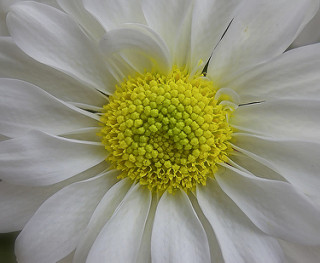

[46 52 38  7  6]
Class ID 46
Prediction oxeye daisy
Score 0.967528
Class ID 52
Prediction sunflower
Score 0.012454
Class ID 38
Prediction barbeton daisy
Score 0.005737
Class ID  7
Prediction king protea
Score 0.004534
Class ID  6
Prediction colt's foot
Score 0.003982


<Figure size 600x1000 with 1 Axes>

In [40]:
# Transform the image
transform = transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
 
# Load and show the image
test_image_name = ".//flower_photos//daisy//100080576_f52e8ee070_n.jpg"
test_image = Image.open(test_image_name)
display(test_image)
 
# Apply the transformations to the input image and convert it into a tensor
test_image_tensor = transform(test_image)
 
# Make the input image ready to be input as a batch of size 1
test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
 
# Convert the tensor to numpy array
np_image = test_image_tensor.numpy()
#print(np_image.shape)
result = p.run([np_image.astype(np.float32)])
topk, topclass = ps.topk(5, dim=1)
print(topclass.data.cpu().numpy()[0])
labels = topclass.data.cpu().numpy()[0]
probs =topk.data.cpu().numpy()[0]
top_flowers = [label_map[idx_to_class[lab]] for lab in labels]

for i in range(5):        
        print("Class ID {:2d}".format(labels[i]))
        print("Prediction " + label_map[idx_to_class[labels[i]]])
        print("Score {:2f}".format(probs[i]))

import matplotlib.pyplot as plt
import seaborn as sns
# Set up plot
plt.figure(figsize = (6,10))

# Plot bar chart
plt.subplot(2,1,2)
sns.barplot(x=probs*100, y=top_flowers, color=sns.color_palette()[0]);
plt.show()

#  2. Load the Pre-Trained Model

In [25]:

# Inference in Caffe2 using the ONNX model
import caffe2.python.onnx.backend as backend
import onnx
 
# First load the onnx model
model = onnx.load("flower_model2.onnx")
 
# Prepare the backend
rep = backend.prepare(model, device="CPU")
 

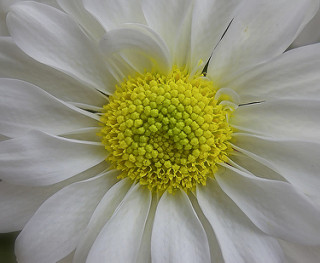

In [26]:
# Transform the image
transform = transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
 
# Load and show the image
test_image_name = ".//flower_photos//daisy//100080576_f52e8ee070_n.jpg"
test_image = Image.open(test_image_name)

 
# Apply the transformations to the input image and convert it into a tensor
test_image_tensor = transform(test_image)
 
# Make the input image ready to be input as a batch of size 1
test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
 
# Convert the tensor to numpy array
np_image = test_image_tensor.numpy()
 

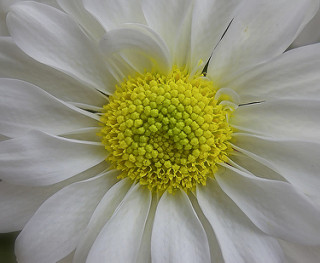

Class ID 46
Prediction oxeye daisy
Score 0.967528


In [29]:
# Pass the numpy array to run through the ONNX model
outputs = rep.run(np_image.astype(np.float32))
  
ps = torch.exp(torch.from_numpy(outputs[0]))
topk, topclass = ps.topk(1, dim=1)

label = topclass.cpu().item()
display(test_image)
print("Class ID {:2d}".format(topclass.cpu().item()))
print("Prediction " + label_map[idx_to_class[label]])
print("Score {:2f}".format(topk.cpu().item()))

## Shipping the models into the Android app
After we are sure that it runs with Predictor, we can copy init_net.pb and predict_net_v1.pb to [project]/app/src/main/assets directory.

Next, let's try to run the app...

TUTORIAL: https://brsoff.github.io/tutorials/advanced/super_resolution_with_caffe2.html

STEPS:
    - install Android NDK https://developer.android.com/ndk/guides#download-ndk
    - adb shell: Android Debug Bridge (adb) is a versatile command-line tool that lets you communicate with a device. The adb command facilitates a variety of device actions, such as installing and debugging apps, and it provides access to a Unix shell that you can use to run a variety of commands on a device. adb is included in the Android SDK Platform-Tools package. You can download this package with the SDK Manager, which installs it at android_sdk/platform-tools/
    - binary speed_benchmark.cc 
    https://github.com/caffe2/AICamera-Style-Transfer/blob/master/app/src/main/cpp/caffe2/binaries/speed_benchmark.cc
    build_android.sh
    https://github.com/pytorch/pytorch/blob/master/scripts/build_android.sh
    
    I tried to find a way, but this is really putting me off!
    Trying a different solution
    
# day 21: trying again
Found more instructions:
https://caffe2.ai/docs/mobile-integration.html
https://github.com/caffe2/caffe2/blob/master/scripts/build_android.sh

https://stackoverflow.com/questions/31827027/run-bash-script-from-android-app
Following instructions on: https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/tools/benchmark
1. Run adb script shell
2. Run build_android.sh
3. Push the benchmark.cc file to the /data/local/temp
'C:\Users\xx\AppData\Local\Android\Sdk\platform-tools>adb push C:\Users\xx\xx\Leren\private-ai\flowers\speed_benchmark.cc /data/local/tmp
'C:\Users\xx\xx\Leren\private-ai\flowers\speed_benchmark.cc: 1 file pushed. 0.1 MB/s (6259 bytes in 0.076s)''

Make the binary executable.

adb shell chmod +x /data/local/tmp/benchmark_model


# Locate and run the adb script shell

see instructions on https://developer.android.com/studio/command-line
Locate your adb:
    go to Files, Project Structure
    select SDK Location: go to the path
    the adb is located under ..AppData\Local\Android\Sdk\platform-tools
    
#### RUN
Start a terminal and go to the location to start the shell command
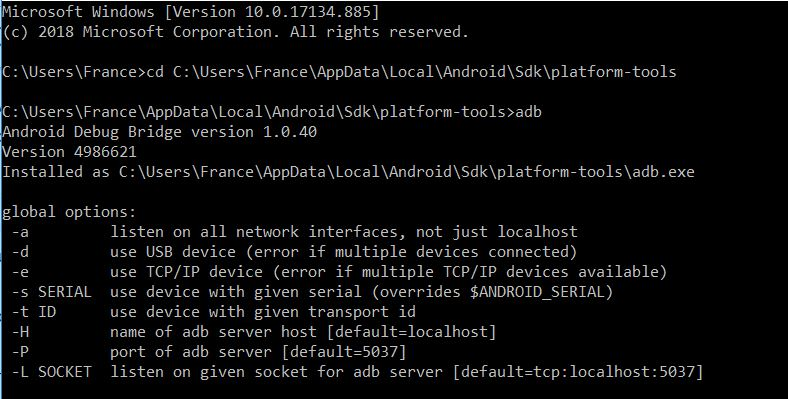

In [3]:
# let's first push a bunch of stuff to adb, specify the path for the binary
CAFFE2_MOBILE_BINARY = ('speed_benchmark.cc')

In [4]:
CAFFE2_MOBILE_BINARY

'speed_benchmark.cc'

In [6]:
import os
# we had saved our init_net and proto_net in steps above, we use them now.
# Push the binary and the model protos
os.system('adb push ' + CAFFE2_MOBILE_BINARY + ' /data/local/tmp/')
os.system('adb push init_net.pb /data/local/tmp')
os.system('adb push predict_net.pb /data/local/tmp')

1

In [46]:
# Let's serialize the input image blob to a blob proto and then send it to mobile for execution.
# push the input image blob to adb
os.system('adb push np_image /data/local/tmp/')


1

In [62]:
# Now we run the net on mobile, look at the speed_benchmark --help for what various options mean
os.system(
    'adb shell /data/local/tmp/speed_benchmark.cc '                     # binary to execute
    '--init_net=/data/local/tmp/init_net.pb '    # mobile init_net
    '--net=/data/local/tmp/predict_net.pb '      # mobile predict_net
    '--input=np_image '                                                     # name of our input image blob
    '--input_file=/data/local/tmp/np_image '                  # serialized input image
    '--output_folder=/data/local/tmp '                               # destination folder for saving mobile output
    '--output=np_image2 '                                                 # output blobs we are interested in
    '--iter=1 '                                                      # number of net iterations to execute
    '--caffe2_log_level=0 '
)


1

In [65]:
# get the model output from adb and save to a file
os.system('adb pull /data/local/tmp/np_image ./saved')

1

In [66]:
!dir saved

 Volume in drive C is OS
 Volume Serial Number is 8C39-2646

 Directory of C:\Users\France\Webtotum\Leren\private-ai\flowers\saved

23-Jul-19  11:09 PM    <DIR>          .
23-Jul-19  11:09 PM    <DIR>          ..
               0 File(s)              0 bytes
               2 Dir(s)  45,856,751,616 bytes free


## ONNX model inference with Tensorflow backend:

In [ ]:
#!pip install onnx_tf

In [1]:
import onnx
from onnx_tf.backend import prepare
import warnings

warnings.filterwarnings('ignore') # Ignore all the warning messages in this tutorial
model = onnx.load('flower_model2.onnx') # Load the ONNX file
tf_rep = prepare(model) # Import the ONNX model to Tensorflow

C:\Users\France\temp-conda\envs\TFPrivateAI\lib\site-packages\onnx_tf\common\__init__.py:87: UserWarning: onnx_tf.common.get_outputs_names is deprecated. It will be removed in future release. Use TensorflowGraph.get_outputs_names instead.
  warnings.warn(message)
W0722 22:05:59.174096 85536 deprecation_wrapper.py:119] From C:\Users\France\temp-conda\envs\TFPrivateAI\lib\site-packages\onnx_tf\handlers\backend\ceil.py:10: The name tf.ceil is deprecated. Please use tf.math.ceil instead.

W0722 22:05:59.189024 85536 deprecation_wrapper.py:119] From C:\Users\France\temp-conda\envs\TFPrivateAI\lib\site-packages\onnx_tf\handlers\backend\depth_to_space.py:12: The name tf.depth_to_space is deprecated. Please use tf.compat.v1.depth_to_space instead.

W0722 22:05:59.194011 85536 deprecation_wrapper.py:119] From C:\Users\France\temp-conda\envs\TFPrivateAI\lib\site-packages\onnx_tf\handlers\backend\erf.py:9: The name tf.erf is deprecated. Please use tf.math.erf instead.

W0722 22:06:00.472321 85536

In [2]:
print(tf_rep.inputs) # Input nodes to the model
print('-----')
print(tf_rep.outputs) # Output nodes from the model
print('-----')
print(tf_rep.tensor_dict) # All nodes in the model

['input.1']
-----
['1549']
-----
{'classifier.fc1.bias': <tf.Tensor 'Const:0' shape=(500,) dtype=float32>, 'classifier.fc1.weight': <tf.Tensor 'Const_1:0' shape=(500, 2208) dtype=float32>, 'classifier.fc2.bias': <tf.Tensor 'Const_2:0' shape=(102,) dtype=float32>, 'classifier.fc2.weight': <tf.Tensor 'Const_3:0' shape=(102, 500) dtype=float32>, 'features.conv0.weight': <tf.Tensor 'Const_4:0' shape=(96, 3, 7, 7) dtype=float32>, 'features.denseblock1.denselayer1.conv1.weight': <tf.Tensor 'Const_5:0' shape=(192, 96, 1, 1) dtype=float32>, 'features.denseblock1.denselayer1.conv2.weight': <tf.Tensor 'Const_6:0' shape=(48, 192, 3, 3) dtype=float32>, 'features.denseblock1.denselayer1.norm1.bias': <tf.Tensor 'Const_7:0' shape=(96,) dtype=float32>, 'features.denseblock1.denselayer1.norm1.num_batches_tracked': <tf.Tensor 'Const_8:0' shape=() dtype=int64>, 'features.denseblock1.denselayer1.norm1.running_mean': <tf.Tensor 'Const_9:0' shape=(96,) dtype=float32>, 'features.denseblock1.denselayer1.norm1

In [5]:
tf_pb_path = 'flower_model2_onnx' + '_graph.pb'
tf_rep.export_graph(tf_pb_path)

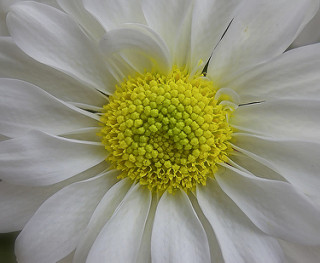

In [17]:
import torch
from PIL import Image
from torchvision import datasets, models, transforms

# Transform the image
transform = transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
# Load and show the image
test_image_name = ".//flower_photos//daisy//100080576_f52e8ee070_n.jpg"
test_image = Image.open(test_image_name)
display(test_image)
 
# Apply the transformations to the input image and convert it into a tensor
test_image_tensor = transform(test_image)
 
# Make the input image ready to be input as a batch of size 1
test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
 
# Convert the tensor to numpy array
np_image = test_image_tensor.numpy()



In [20]:
#https://github.com/cinastanbean/pytorch-onnx-tensorflow-pb/blob/master/Converting%20A%20PyTorch%20Model%20to%20Tensorflow%20pb%20using%20ONNX.html
output_onnx_tf = tf_rep.run(np_image.astype(np.float32))

In [ ]:
ps = torch.exp(torch.from_numpy(output_onnx_tf[0]))
topk, topclass = ps.topk(1, dim=1)

label = topclass.cpu().item()
print("Class ID {:2d}".format(topclass.cpu().item()))
print("Prediction " + label_map[idx_to_class[label]])
print("Score {:2f}".format(topk.cpu().item()))